In [1]:
# Подключаем необходимые модули
import family, sgd

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Сиды для воспроизводимости результатов
seed_params = 123
seed_regressors = 10
seed_response = 4
seed_sgd = 1

In [2]:
def adj_r2(y, y_pred, n_params):
    n = len(y)
    error = y - y_pred
    r2 = 1 - np.sum(error**2) / np.sum((y - np.mean(y)) ** 2)
    return 1 - (1 - r2) * (n - 1) / (n - n_params - 1)

def pseudo_r2(y, y_pred, family: family.Family):
    d_fitted = family.deviance(y, y_pred) 
    d_null = family.deviance(y, np.mean(y))
    return 1 - d_fitted / d_null

## Проверка на сгенерированных данных


Пусть количество индивидов равно $n=1000$, количество признаков равно $p=10$ (без учета константы).


In [3]:
n, p = 1000, 10

In [4]:
# Генерация параметров
np.random.seed(seed_params)
params = np.random.uniform(-10, 10, p + 1)
params

array([ 3.92938371, -4.2772133 , -5.46297093,  1.02629538,  4.3893794 ,
       -1.5378708 ,  9.61528397,  3.69659477, -0.38136197, -2.15764964,
       -3.13643968])

In [5]:
# Генерация регрессоров
np.random.seed(seed_regressors)
X = np.random.rand(n, p)
# Константный член
X = sm.add_constant(X)
column_names = np.append("const", [f"x{i}" for i in range(1, p + 1)])

### 1. Линейная регрессия (Gaussian GLM)


Потность нормального распределения: $$p(y; \mu, \sigma^2)=\frac1{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{(x-\mu)^2}{2\sigma^2}\right\},\quad y\in \mathbb{R}.$$


Матожидание и дисперсия: $\mathsf E y = \mu$, $\mathsf D y=\sigma^2=\phi$. Логарифм правдоподобия: $$L(\mathbf{y}; \mu, \phi)=-\frac{n}{2}\ln2\pi\phi-\frac{1}{2\phi}\sum_{i=1}^n(y_i-\mu)^2.$$


Предполагается, что $\mathsf E(\mathbf{y}~|~\mathbf{X})=\boldsymbol\mu=\mathbf{X} \boldsymbol\beta$, где $\mathbf{X}$ — матрица данных, $\boldsymbol\beta$ — вектор параметров. Поскольку параметр $\phi$ неизвестен, необходимо оптимизировать функцию потерь и по $\phi$. Тогда градиент логарифма правдоподобия выглядят следующим образом: $$\frac{\partial L}{\partial\boldsymbol\beta}=\frac1\phi\mathbf{X}^\mathrm{T}(\mathbf{y}-\boldsymbol\mu),\quad \frac{\partial L}{\partial \phi}=-\frac{n}{2\phi} + \frac{1}{2\phi^2}\sum_{i=1}^n(y_i-\mu_i)^2.$$


In [6]:
# Параметры нормального распределения
mu = X.dot(params)
sigma = 0.1

In [7]:
# Генерация отклика
np.random.seed(seed_response)
y1 = mu + np.random.normal(0, sigma, n)

In [8]:
np.random.seed(seed_sgd)
model1 = sgd.SGD(family=family.Gaussian(), lr=0.03, batch_size=16)
model1.fit(X, y1)

In [9]:
result1 = pd.DataFrame(index=column_names)
result1["Estimated"] = model1.params
result1["True"] = params
print(
    result1,
    f"Epochs passed: {model1.n_iter}",
    f"Dispersion: {model1.dispersion}",
    f"Adjusted R-squared: {adj_r2(y1, model1.predict(X), p)}",
    sep="\n",
)

       Estimated      True
const   3.935208  3.929384
x1     -4.254903 -4.277213
x2     -5.470059 -5.462971
x3      1.028168  1.026295
x4      4.379706  4.389379
x5     -1.544207 -1.537871
x6      9.620079  9.615284
x7      3.711597  3.696595
x8     -0.383994 -0.381362
x9     -2.180469 -2.157650
x10    -3.131106 -3.136440
Epochs passed: 69
Dispersion: 0.008969032084244847
Adjusted R-squared: 0.9994550236678179


Dispersion — параметр дисперсии $\phi$.

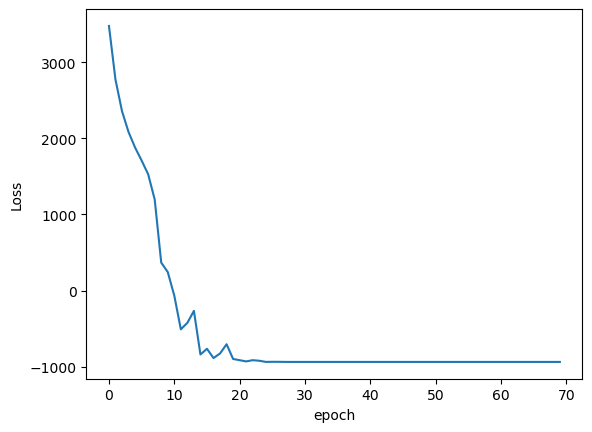

In [10]:
# График функции потерь
plt.plot(model1.loss_history)
plt.xlabel("epoch"), plt.ylabel("Loss")
plt.show()

### 2. Gamma GLM


Плотность выглядит следующим образом: $$p(y; k, \theta) = \frac{y^{k-1}}{\Gamma(k)\theta^k}\exp\left\{-\frac{y}{\theta}\right\},\quad y > 0,\quad k, \theta > 0.$$


Математическое ожидание и дисперсия равны соответственно $\mathsf E y = \theta/\phi = \mu$ и $\mathsf D y = \mu^2 \phi$, где $\phi=1/k$ . Перепараметризуем плотность: $$p(y; \mu, \phi)=\frac{1}{y\Gamma(1/\phi)}\left(\frac{y}{\phi\mu}\right)^{1/\phi} \exp\left\{-\frac{y}{\phi\mu}\right\},\quad y > 0,\quad \mu,\phi>0.$$


В качестве линк-функции возьмем $g(x)=\log(x)$ (ee обратная $g^{-1}(x)=\exp(x)$ преобразует все вещественные числа в положительные). Тогда, предпологая, что $\mathsf E(\mathbf{y}~|~\mathbf{X})=\boldsymbol\mu = g^{-1}\left(\mathbf{X}\boldsymbol\beta\right)$, логарифм функции правдоподобия равен $$L(\mathbf{y}; \boldsymbol\beta, \phi)=-n\ln\Gamma(1/\phi)+\sum_{i=1}^n\left[\frac1\phi\ln\frac{y_i}{\phi\mu_i} - \ln y_i- \frac{y_i}{\phi\mu_i} \right].$$


Дифференцируя по вектору параметров $\boldsymbol\beta$ и $\phi$, получаем формулу градиента: $$\frac{\partial L}{\partial \boldsymbol\beta}=\frac1\phi\mathbf{X}^\mathrm{T} (\mathbf{y} - \boldsymbol\mu) / \boldsymbol\mu,\quad \frac{\partial L}{\partial \phi}=\frac1{\phi^2}\left(n \cdot\psi(1 / \phi) - n + \sum_{i=1}^n\left[-\ln\frac{y_i}{\phi\mu_i}+ \frac{y_i}{\mu_i}\right]\right),$$ где деление производится поэлементно, $\psi(x)=\Gamma^\prime(x)/\Gamma(x)$ — дигамма-функция.


In [11]:
# Параметры гамма-распределения
k = 5
mu = np.exp(X.dot(params))
theta = mu / k

In [12]:
# Генерация отклика
np.random.seed(seed_response)
y2 = np.random.gamma(k, theta, n)

In [13]:
np.random.seed(seed_sgd)
model2 = sgd.SGD(family=family.Gamma(), lr=0.03, batch_size=16)
model2.fit(X, y2)

In [14]:
result2 = pd.DataFrame(index=column_names)
result2["Estimated"] = model2.params
result2["True"] = params
print(
    result2,
    f"Epochs passed: {model2.n_iter}",
    f"Dispersion: {model2.dispersion}",
    f"Pseudo R-squared: {pseudo_r2(y2, model2.predict(X), family.Gamma())}",
    sep="\n",
)

       Estimated      True
const   3.812188  3.929384
x1     -4.262110 -4.277213
x2     -5.428812 -5.462971
x3      1.033868  1.026295
x4      4.326898  4.389379
x5     -1.561227 -1.537871
x6      9.630878  9.615284
x7      3.798322  3.696595
x8     -0.290494 -0.381362
x9     -2.169047 -2.157650
x10    -3.060214 -3.136440
Epochs passed: 82
Dispersion: 0.18610182680985168
Pseudo R-squared: 0.9851416380467808


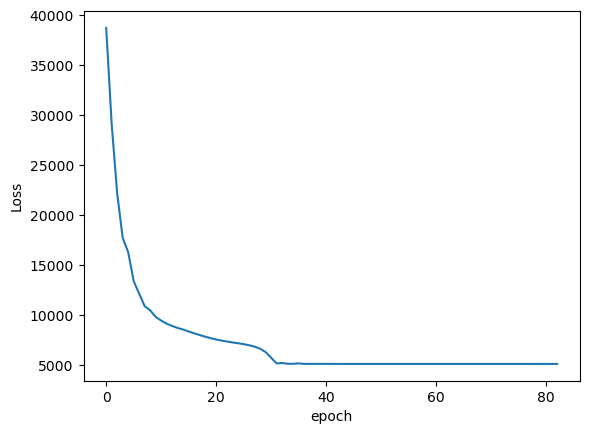

In [15]:
plt.plot(model2.loss_history)
plt.xlabel("epoch"), plt.ylabel("Loss")
plt.show()

## Реальные данные


In [16]:
# Загрузка данных
df = pd.read_csv("data/Real estate.csv", sep=",")
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [17]:
# Переименуем столбцы и выкинем столбец "No"
df.rename(
    columns={
        "X1 transaction date": "transact_date",
        "X2 house age": "house_age",
        "X3 distance to the nearest MRT station": "distance_nearest",
        "X4 number of convenience stores": "n_stores",
        "X5 latitude": "lat",
        "X6 longitude": "lon",
        "Y house price of unit area": "price",
    },
    inplace=True,
)
df.drop("No", axis=1, inplace=True)
df.head(5)

,transact_date,house_age,distance_nearest,n_stores,lat,lon,price
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [18]:
# Размеры датасета
df.shape

(414, 7)

In [19]:
# Описательная статистика, проверка на некорректные данные
df.describe()

,transact_date,house_age,distance_nearest,n_stores,lat,lon,price
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


<Axes: xlabel='price', ylabel='Count'>

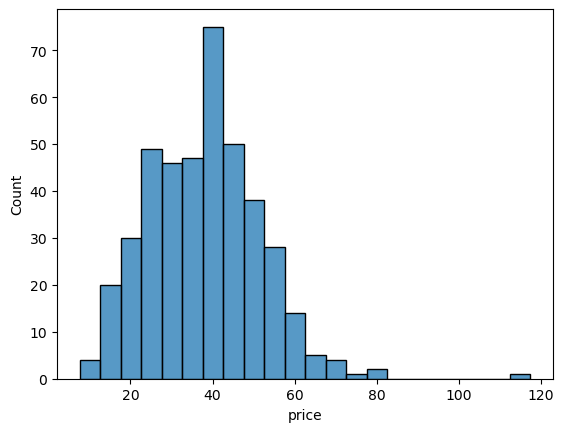

In [20]:
# Зависимая переменная
target = df.price
df.drop("price", axis=1, inplace=True)

sns.histplot(target)

In [21]:
# Перед применением стандартизуем данные
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

# Добавляем константну
df_scaled = sm.add_constant(df_scaled)

Обучим линейную регрессию и GLM с гамма-распределением.

### 1. Линейная регрессия

In [22]:
np.random.seed(seed_sgd)
lm = sgd.SGD(family=family.Gaussian(), lr=0.1, batch_size=16)
lm.fit(df_scaled.to_numpy(), target.to_numpy())

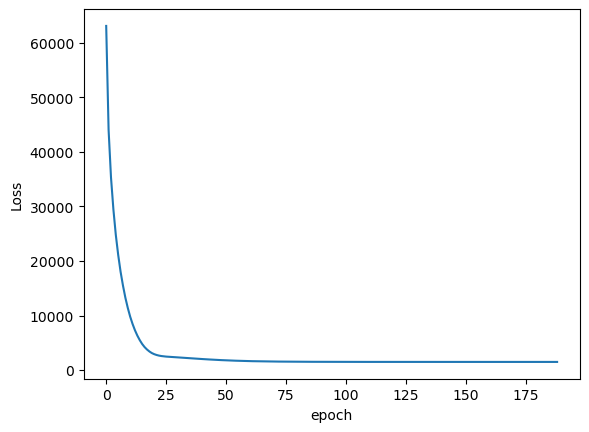

In [23]:
plt.plot(lm.loss_history)
plt.xlabel("epoch"), plt.ylabel("Loss")
plt.show()

In [24]:
print(
    f"{pd.Series(lm.params, index=df_scaled.columns).to_string()}",
    f"Epochs passed: {lm.n_iter}",
    f"Dispersion: {lm.dispersion}",
    f"Adjusted R-squared: {adj_r2(target, lm.predict(df_scaled), df.shape[1])}",
    sep="\n",
)

const               37.976997
transact_date        1.446827
house_age           -3.055246
distance_nearest    -5.660887
n_stores             3.373381
lat                  2.809412
lon                 -0.187202
Epochs passed: 188
Dispersion: 72.59839578031595
Adjusted R-squared: 0.5761972934946034


Сравним полученные результаты с SGD из библиотеки sklearn.

In [25]:
from sklearn.linear_model import SGDRegressor
np.random.seed(seed_sgd)
lm_sklearn = SGDRegressor(learning_rate="adaptive", eta0=0.1, penalty=None, fit_intercept=False)
lm_sklearn.fit(df_scaled, target)

SGDRegressor(eta0=0.1, fit_intercept=False, learning_rate='adaptive',
             penalty=None)

In [26]:
print(
    f"{pd.Series(lm_sklearn.coef_, index=df_scaled.columns).to_string()}",
    f"Epochs passed: {lm_sklearn.n_iter_}",
    f"Adjusted R-squared: {adj_r2(target, lm_sklearn.predict(df_scaled), df.shape[1])}",
    sep="\n",
)

const               37.985638
transact_date        1.461966
house_age           -3.070485
distance_nearest    -5.635479
n_stores             3.339555
lat                  2.805714
lon                 -0.177384
Epochs passed: 62
Adjusted R-squared: 0.5762117458356961


### 2. Gamma GLM

In [27]:
np.random.seed(seed_sgd)
glm = sgd.SGD(family=family.Gamma(), lr=0.01, batch_size=16)
glm.fit(df_scaled.to_numpy(), target.to_numpy())

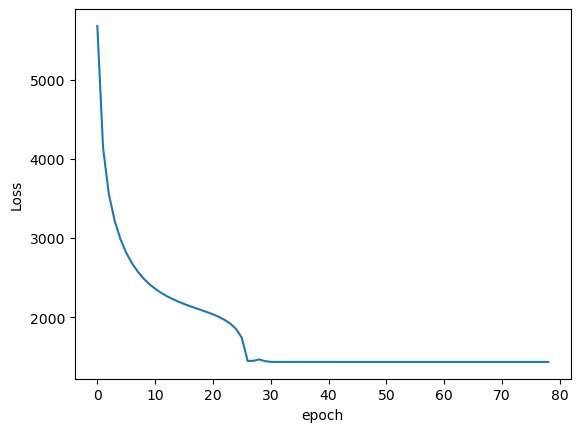

In [28]:
plt.plot(glm.loss_history)
plt.xlabel("epoch"), plt.ylabel("Loss")
plt.show()

In [29]:
print(
    f"{pd.Series(glm.params, index=df_scaled.columns).to_string()}",
    f"Epochs passed: {glm.n_iter}",
    f"Dispersion: {glm.dispersion}",
    f"Pseudo R-squared: {pseudo_r2(target, glm.predict(df_scaled), family.Gamma())}",
    sep="\n",
)

const               3.591820
transact_date       0.046941
house_age          -0.073330
distance_nearest   -0.199475
n_stores            0.074807
lat                 0.087781
lon                -0.004894
Epochs passed: 78
Dispersion: 0.048081105038927756
Pseudo R-squared: 0.6599475913259423


Сравним полученные результаты с GLM из библиотеки statmodels.

In [30]:
glm_sm = sm.GLM(target, df_scaled, family=sm.families.Gamma(sm.families.links.Log()))
results = glm_sm.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                  414
Model:                            GLM   Df Residuals:                      407
Model Family:                   Gamma   Df Model:                            6
Link Function:                    Log   Scale:                        0.053814
Method:                          IRLS   Log-Likelihood:                -1438.1
Date:                Sun, 01 Dec 2024   Deviance:                       19.812
Time:                        23:33:21   Pearson chi2:                     21.9
No. Iterations:                    12   Pseudo R-squ. (CS):             0.8220
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.5906      0.011  

In [31]:
pseudo_r2(target, results.predict(df_scaled), family.Gamma())

0.6599760918054027